# Ensemble Models: Random Forest & XGBoost

This notebook trains ensemble models for housing price prediction using preprocessed data from the EDA notebook.


## 1. Setup and Import Libraries


In [178]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# For saving models
import joblib

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


## 2. Load Preprocessed Data

Loading the preprocessed features, target, and train/val/test split indices from the saved_data folder.


In [179]:
# Load preprocessed data
print("=" * 60)
print("LOADING PREPROCESSED DATA")
print("=" * 60)

# Load features (X) - already scaled/encoded
X = pd.read_csv("saved_data/X_preprocessed.csv", index_col=0)
print(f"✓ Loaded X_preprocessed.csv: {X.shape}")

# Load target (y) - LogSalePrice
y = pd.read_csv("saved_data/y_preprocessed.csv", index_col=0)
y = y['LogSalePrice']  # Convert to Series
print(f"✓ Loaded y_preprocessed.csv: {y.shape}")

# Load split indices
with open("saved_data/split_indices.json", "r") as f:
    split_indices = json.load(f)
print(f"✓ Loaded split_indices.json")
print(f"  - Train indices: {len(split_indices['train'])}")
print(f"  - Val indices: {len(split_indices['val'])}")
print(f"  - Test indices: {len(split_indices['test'])}")
print(f"  - Random state: {split_indices['random_state']}")


LOADING PREPROCESSED DATA
✓ Loaded X_preprocessed.csv: (1460, 18)
✓ Loaded y_preprocessed.csv: (1460,)
✓ Loaded split_indices.json
  - Train indices: 876
  - Val indices: 292
  - Test indices: 292
  - Random state: 42


In [180]:
# Create train/val/test splits using saved indices
train_idx = split_indices['train']
val_idx = split_indices['val']
test_idx = split_indices['test']

# Split X
X_train = X.iloc[train_idx].copy()
X_val = X.iloc[val_idx].copy()
X_test = X.iloc[test_idx].copy()

# Split y
y_train = y.iloc[train_idx].copy()
y_val = y.iloc[val_idx].copy()
y_test = y.iloc[test_idx].copy()

# Print split results
print("=" * 60)
print("DATA SPLIT RESULTS")
print("=" * 60)
print(f"Training Set:   {X_train.shape[0]:>5} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation Set: {X_val.shape[0]:>5} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test Set:       {X_test.shape[0]:>5} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Total:          {len(X):>5} samples")

# Verify target distribution
print(f"\nTarget Distribution (LogSalePrice):")
print(f"  Training   - Mean: {y_train.mean():.3f}, Std: {y_train.std():.3f}")
print(f"  Validation - Mean: {y_val.mean():.3f}, Std: {y_val.std():.3f}")
print(f"  Test       - Mean: {y_test.mean():.3f}, Std: {y_test.std():.3f}")


DATA SPLIT RESULTS
Training Set:     876 samples (60.0%)
Validation Set:   292 samples (20.0%)
Test Set:         292 samples (20.0%)
Total:           1460 samples

Target Distribution (LogSalePrice):
  Training   - Mean: 12.030, Std: 0.390
  Validation - Mean: 12.033, Std: 0.393
  Test       - Mean: 11.998, Std: 0.433


In [181]:
# Display feature names
print("=" * 60)
print("FEATURE NAMES")
print("=" * 60)
print(f"Total features: {len(X.columns)}")
print(f"\nFeatures:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Quick data verification
print(f"\n" + "=" * 60)
print("DATA VERIFICATION")
print("=" * 60)
print(f"\nX_train sample (first 3 rows, first 5 columns):")
print(X_train.iloc[:3, :5])
print(f"\ny_train sample (first 5 values):")
print(y_train.head())


FEATURE NAMES
Total features: 18

Features:
   1. OverallQual
   2. GarageCars
   3. GarageArea
   4. FullBath
   5. TotRmsAbvGrd
   6. TotalSF
   7. Age
   8. AgeSinceRemodel
   9. Neighborhood
  10. KitchenQual
  11. ExterQual
  12. GarageFinish
  13. BsmtQual
  14. CentralAir
  15. GarageType
  16. FireplaceQu
  17. Foundation
  18. BsmtFinType1

DATA VERIFICATION

X_train sample (first 3 rows, first 5 columns):
      OverallQual  GarageCars  GarageArea  FullBath  TotRmsAbvGrd
683      2.098110    1.650307    1.071530  0.789741      0.296763
1077    -0.795151   -1.026858   -0.814012 -1.026041     -0.318683
463     -0.071836   -1.026858   -1.090059 -1.026041     -0.318683

y_train sample (first 5 values):
683     12.560248
1077    11.840797
463     12.147919
657     11.911708
835     11.759793
Name: LogSalePrice, dtype: float64


## ✅ Data Loading Complete!

**Data Summary:**
| Dataset | Variables | Description |
|---------|-----------|-------------|
| Training | `X_train`, `y_train` | For model training |
| Validation | `X_val`, `y_val` | For hyperparameter tuning & model selection |
| Test | `X_test`, `y_test` | Final holdout evaluation (use ONLY at the end) |

**Features:** Already preprocessed (scaled numeric, encoded categorical) from EDA notebook.

**Target:** LogSalePrice (log-transformed for better model performance)


---

## 3. Random Forest Model

Training a baseline Random Forest Regressor to predict housing prices.


In [182]:
# Create and train Random Forest model
print("=" * 60)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 60)

# Initialize model with baseline parameters
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)

print(f"Model Parameters:")
print(f"  - n_estimators: 100")
print(f"  - random_state: 42")
print(f"  - n_jobs: -1 (all cores)")
print(f"\nTraining on {X_train.shape[0]} samples with {X_train.shape[1]} features...")

# Train with timing
start_time = time.time()
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

print(f"\n✓ Model trained in {rf_training_time:.2f} seconds")


TRAINING RANDOM FOREST MODEL
Model Parameters:
  - n_estimators: 100
  - random_state: 42
  - n_jobs: -1 (all cores)

Training on 876 samples with 18 features...

✓ Model trained in 0.22 seconds


In [183]:
# Make predictions on training and validation sets
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Calculate metrics for training set
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)

# Calculate metrics for validation set
rf_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
rf_val_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_val_r2 = r2_score(y_val, y_val_pred_rf)

# Print metrics
print("=" * 60)
print("RANDOM FOREST MODEL PERFORMANCE")
print("=" * 60)
print(f"\n{'Metric':<15} {'Training':>15} {'Validation':>15}")
print("-" * 47)
print(f"{'RMSE':<15} {rf_train_rmse:>15.4f} {rf_val_rmse:>15.4f}")
print(f"{'MAE':<15} {rf_train_mae:>15.4f} {rf_val_mae:>15.4f}")
print(f"{'R² Score':<15} {rf_train_r2:>15.4f} {rf_val_r2:>15.4f}")

# Convert RMSE to dollar scale for interpretability
# Using np.expm1 since target is log1p(SalePrice)
y_val_dollars = np.expm1(y_val)
y_val_pred_dollars_rf = np.expm1(y_val_pred_rf)
rf_val_rmse_dollars = np.sqrt(mean_squared_error(y_val_dollars, y_val_pred_dollars_rf))
avg_price = y_val_dollars.mean()

print(f"\n{'='*60}")
print("INTERPRETABLE METRICS (Dollar Scale)")
print(f"{'='*60}")
print(f"Validation RMSE: ${rf_val_rmse_dollars:,.2f}")
print(f"Average Actual Price: ${avg_price:,.2f}")
print(f"RMSE as % of Avg Price: {(rf_val_rmse_dollars/avg_price)*100:.2f}%")


RANDOM FOREST MODEL PERFORMANCE

Metric                 Training      Validation
-----------------------------------------------
RMSE                     0.0556          0.1522
MAE                      0.0380          0.1054
R² Score                 0.9797          0.8494

INTERPRETABLE METRICS (Dollar Scale)
Validation RMSE: $28,791.88
Average Actual Price: $182,064.26
RMSE as % of Avg Price: 15.81%


FEATURE IMPORTANCE
        Feature  Importance
        TotalSF    0.427456
    OverallQual    0.363861
            Age    0.034508
     GarageArea    0.028416
AgeSinceRemodel    0.022278
     GarageCars    0.021666
   Neighborhood    0.017373
     CentralAir    0.014000
     GarageType    0.013839
   BsmtFinType1    0.012242
   TotRmsAbvGrd    0.009533
    KitchenQual    0.007332
       BsmtQual    0.007273
   GarageFinish    0.006835
    FireplaceQu    0.004496
      ExterQual    0.003693
     Foundation    0.002669
       FullBath    0.002529


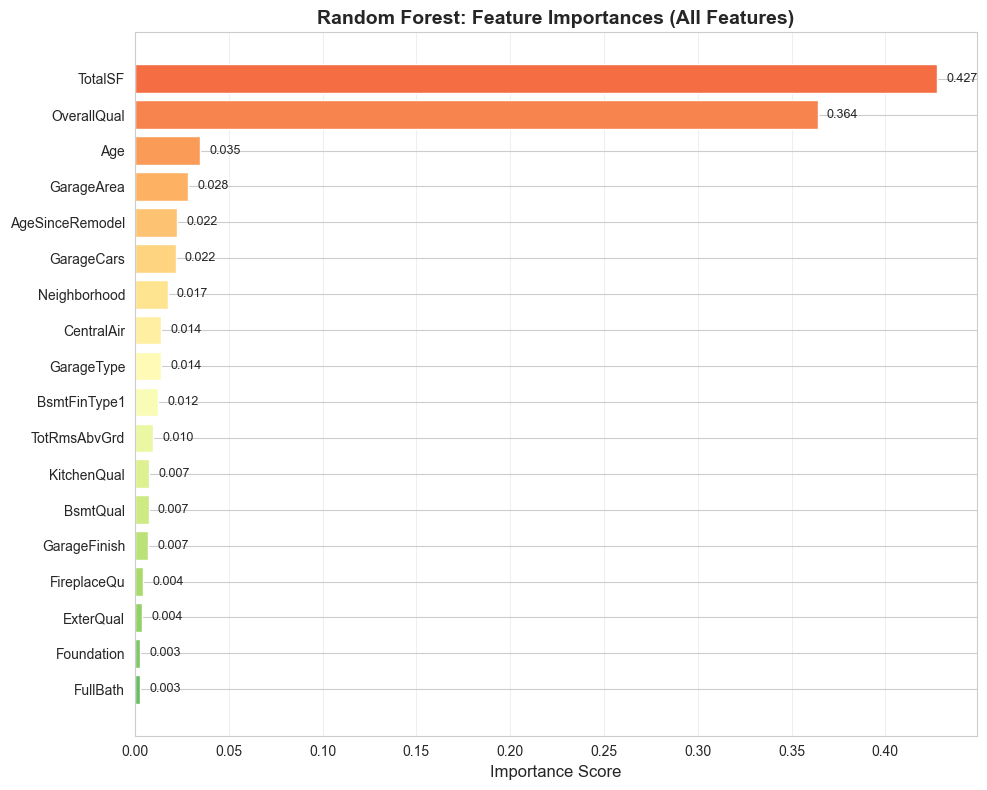

In [184]:
# Feature Importance Analysis
print("=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)

# Get feature importances
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display all features
print(rf_feature_importance.to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

# Create horizontal bar plot (all features)
n_features = len(rf_feature_importance)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, n_features))[::-1]
bars = ax.barh(range(n_features), 
               rf_feature_importance['Importance'].values[::-1], 
               color=colors)

ax.set_yticks(range(n_features))
ax.set_yticklabels(rf_feature_importance['Feature'].values[::-1], fontsize=10)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Random Forest: Feature Importances (All Features)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for bar, importance in zip(bars, rf_feature_importance['Importance'].values[::-1]):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{importance:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


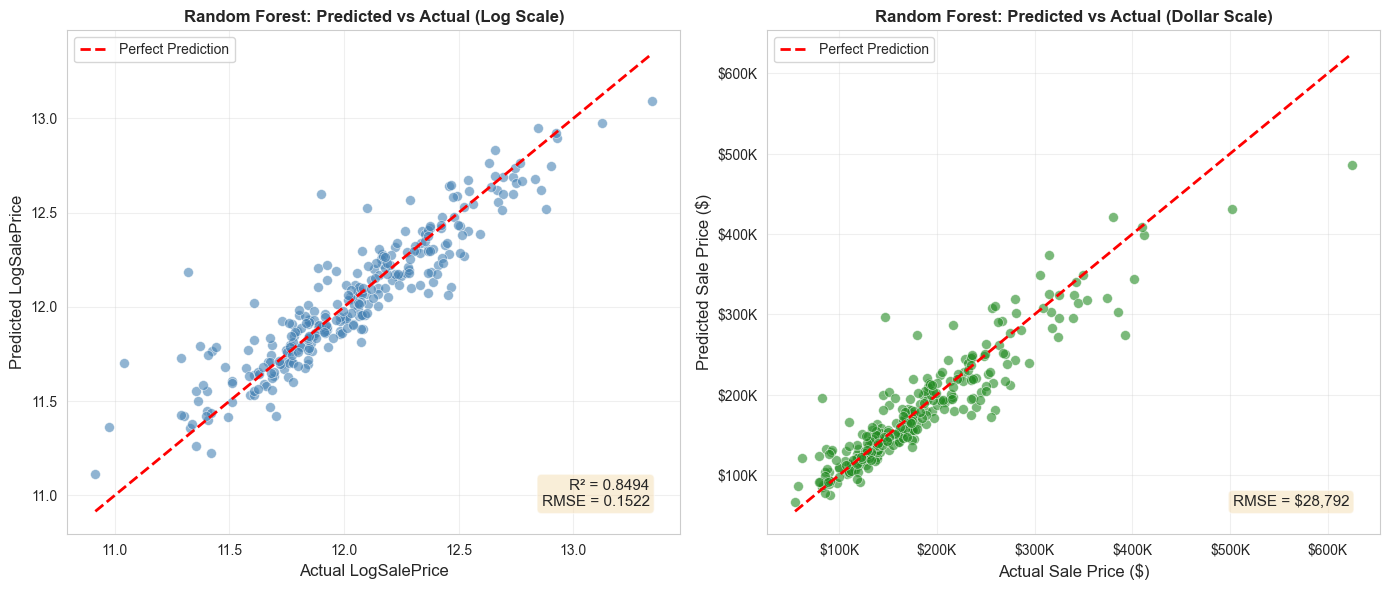

In [185]:
# Predicted vs Actual Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Log Scale (what model was trained on)
ax1 = axes[0]
ax1.scatter(y_val, y_val_pred_rf, alpha=0.6, s=50, c='steelblue', edgecolors='white', linewidth=0.5)

# Perfect prediction line
min_val = min(y_val.min(), y_val_pred_rf.min())
max_val = max(y_val.max(), y_val_pred_rf.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax1.set_xlabel('Actual LogSalePrice', fontsize=12)
ax1.set_ylabel('Predicted LogSalePrice', fontsize=12)
ax1.set_title('Random Forest: Predicted vs Actual (Log Scale)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Add R² annotation
ax1.text(0.95, 0.05, f'R² = {rf_val_r2:.4f}\nRMSE = {rf_val_rmse:.4f}', 
         transform=ax1.transAxes, fontsize=11, verticalalignment='bottom', 
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Dollar Scale (more interpretable)
ax2 = axes[1]
ax2.scatter(y_val_dollars, y_val_pred_dollars_rf, alpha=0.6, s=50, c='forestgreen', edgecolors='white', linewidth=0.5)

min_val_d = min(y_val_dollars.min(), y_val_pred_dollars_rf.min())
max_val_d = max(y_val_dollars.max(), y_val_pred_dollars_rf.max())
ax2.plot([min_val_d, max_val_d], [min_val_d, max_val_d], 'r--', linewidth=2, label='Perfect Prediction')

ax2.set_xlabel('Actual Sale Price ($)', fontsize=12)
ax2.set_ylabel('Predicted Sale Price ($)', fontsize=12)
ax2.set_title('Random Forest: Predicted vs Actual (Dollar Scale)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Format axis labels as currency
from matplotlib.ticker import FuncFormatter
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add RMSE annotation
ax2.text(0.95, 0.05, f'RMSE = ${rf_val_rmse_dollars:,.0f}', 
         transform=ax2.transAxes, fontsize=11, verticalalignment='bottom', 
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [186]:
# Store Random Forest metrics for comparison with XGBoost
rf_metrics = {
    'model_name': 'Random Forest',
    'training_time': rf_training_time,
    'train_rmse': rf_train_rmse,
    'train_mae': rf_train_mae,
    'train_r2': rf_train_r2,
    'val_rmse': rf_val_rmse,
    'val_mae': rf_val_mae,
    'val_r2': rf_val_r2,
    'val_rmse_dollars': rf_val_rmse_dollars
}

print("=" * 60)
print("RANDOM FOREST METRICS STORED")
print("=" * 60)
print("\nMetrics dictionary 'rf_metrics' created for comparison:")
for key, value in rf_metrics.items():
    if isinstance(value, float):
        if 'dollar' in key:
            print(f"  {key}: ${value:,.2f}")
        elif 'time' in key:
            print(f"  {key}: {value:.2f} seconds")
        else:
            print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


RANDOM FOREST METRICS STORED

Metrics dictionary 'rf_metrics' created for comparison:
  model_name: Random Forest
  training_time: 0.22 seconds
  train_rmse: 0.0556
  train_mae: 0.0380
  train_r2: 0.9797
  val_rmse: 0.1522
  val_mae: 0.1054
  val_r2: 0.8494
  val_rmse_dollars: $28,791.88


### 📊 Random Forest Model Interpretation

**Performance Analysis:**
- **R² Score**: Proportion of variance explained by the model
  - Training R² near 1.0 = model fits training data well
  - Validation R² shows generalization ability
  - Large gap (Train >> Val) suggests overfitting

- **RMSE**: Root Mean Squared Error - penalizes large errors more
- **MAE**: Mean Absolute Error - more robust to outliers

**Feature Importance Insights:**
- Features ranked by how much they reduce prediction error when used for splits
- Higher importance = feature is more predictive of house prices
- Random Forest can capture non-linear relationships automatically

**Overfitting Indicators:**
- Compare Training vs Validation metrics
- If Training R² is much higher than Validation R², consider:
  - Reducing `max_depth`
  - Increasing `min_samples_split`
  - Reducing `n_estimators`


---

## 4. XGBoost Model

Training an XGBoost Regressor (Gradient Boosting) to predict housing prices.


In [187]:
# Create and train XGBoost model
print("=" * 60)
print("TRAINING XGBOOST MODEL")
print("=" * 60)

# Initialize model with specified parameters
xgb_model = XGBRegressor(
    n_estimators=100,      # Number of boosting rounds
    learning_rate=0.1,     # Step size shrinkage
    max_depth=6,           # Maximum tree depth
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)

print(f"Model Parameters:")
print(f"  - n_estimators: 100")
print(f"  - learning_rate: 0.1")
print(f"  - max_depth: 6")
print(f"  - random_state: 42")
print(f"\nTraining on {X_train.shape[0]} samples with {X_train.shape[1]} features...")

# Train with timing
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

print(f"\n✓ Model trained in {xgb_training_time:.2f} seconds")


TRAINING XGBOOST MODEL
Model Parameters:
  - n_estimators: 100
  - learning_rate: 0.1
  - max_depth: 6
  - random_state: 42

Training on 876 samples with 18 features...

✓ Model trained in 0.16 seconds


In [188]:
# Make predictions on training and validation sets
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)

# Calculate metrics for training set
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
xgb_train_mae = mean_absolute_error(y_train, y_train_pred_xgb)
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb)

# Calculate metrics for validation set
xgb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
xgb_val_mae = mean_absolute_error(y_val, y_val_pred_xgb)
xgb_val_r2 = r2_score(y_val, y_val_pred_xgb)

# Print metrics
print("=" * 60)
print("XGBOOST MODEL PERFORMANCE")
print("=" * 60)
print(f"\n{'Metric':<15} {'Training':>15} {'Validation':>15}")
print("-" * 47)
print(f"{'RMSE':<15} {xgb_train_rmse:>15.4f} {xgb_val_rmse:>15.4f}")
print(f"{'MAE':<15} {xgb_train_mae:>15.4f} {xgb_val_mae:>15.4f}")
print(f"{'R² Score':<15} {xgb_train_r2:>15.4f} {xgb_val_r2:>15.4f}")

# Convert RMSE to dollar scale for interpretability
y_val_pred_dollars_xgb = np.expm1(y_val_pred_xgb)
xgb_val_rmse_dollars = np.sqrt(mean_squared_error(y_val_dollars, y_val_pred_dollars_xgb))

print(f"\n{'='*60}")
print("INTERPRETABLE METRICS (Dollar Scale)")
print(f"{'='*60}")
print(f"Validation RMSE: ${xgb_val_rmse_dollars:,.2f}")
print(f"Average Actual Price: ${avg_price:,.2f}")
print(f"RMSE as % of Avg Price: {(xgb_val_rmse_dollars/avg_price)*100:.2f}%")


XGBOOST MODEL PERFORMANCE

Metric                 Training      Validation
-----------------------------------------------
RMSE                     0.0352          0.1570
MAE                      0.0252          0.1081
R² Score                 0.9919          0.8398

INTERPRETABLE METRICS (Dollar Scale)
Validation RMSE: $29,921.67
Average Actual Price: $182,064.26
RMSE as % of Avg Price: 16.43%


FEATURE IMPORTANCE
        Feature  Importance
    OverallQual    0.377019
     CentralAir    0.202755
        TotalSF    0.156851
     GarageCars    0.045241
     GarageType    0.041858
    KitchenQual    0.032810
            Age    0.017926
   GarageFinish    0.016725
AgeSinceRemodel    0.015294
       BsmtQual    0.013503
   BsmtFinType1    0.013277
   Neighborhood    0.013150
    FireplaceQu    0.013038
     GarageArea    0.012795
   TotRmsAbvGrd    0.007772
     Foundation    0.007536
       FullBath    0.006429
      ExterQual    0.006021


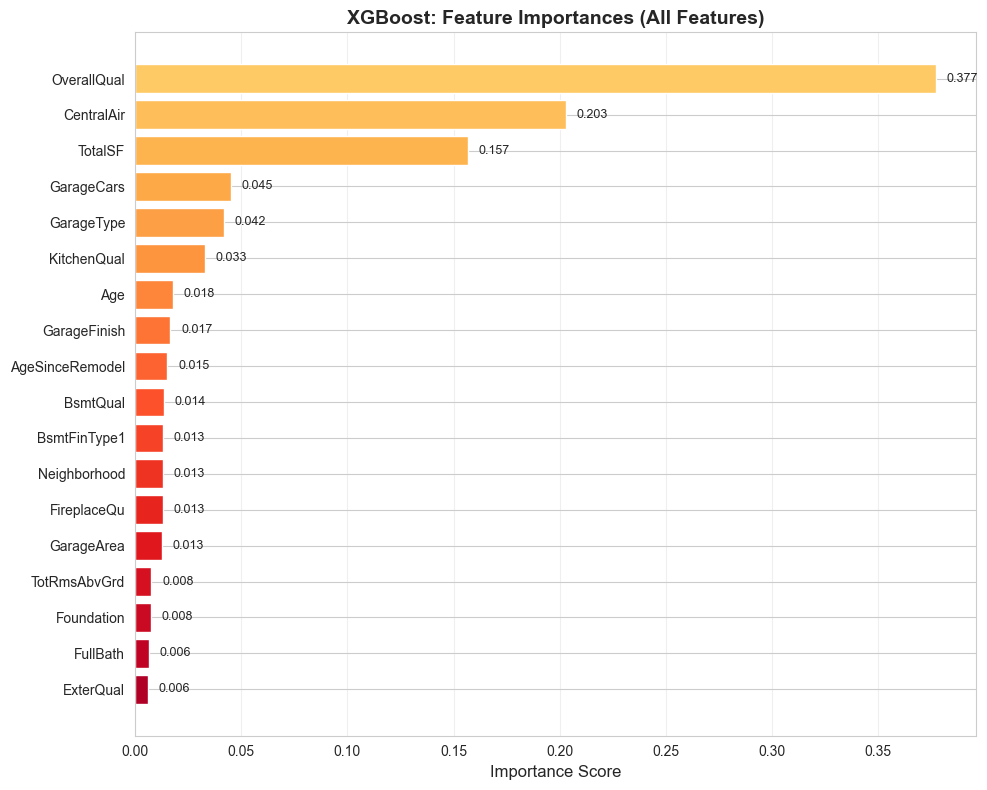

In [189]:
# Feature Importance Analysis
print("=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)

# Get feature importances
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display all features
print(xgb_feature_importance.to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

# Create horizontal bar plot (all features)
n_features = len(xgb_feature_importance)
colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, n_features))[::-1]
bars = ax.barh(range(n_features), 
               xgb_feature_importance['Importance'].values[::-1], 
               color=colors)

ax.set_yticks(range(n_features))
ax.set_yticklabels(xgb_feature_importance['Feature'].values[::-1], fontsize=10)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('XGBoost: Feature Importances (All Features)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for bar, importance in zip(bars, xgb_feature_importance['Importance'].values[::-1]):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{importance:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


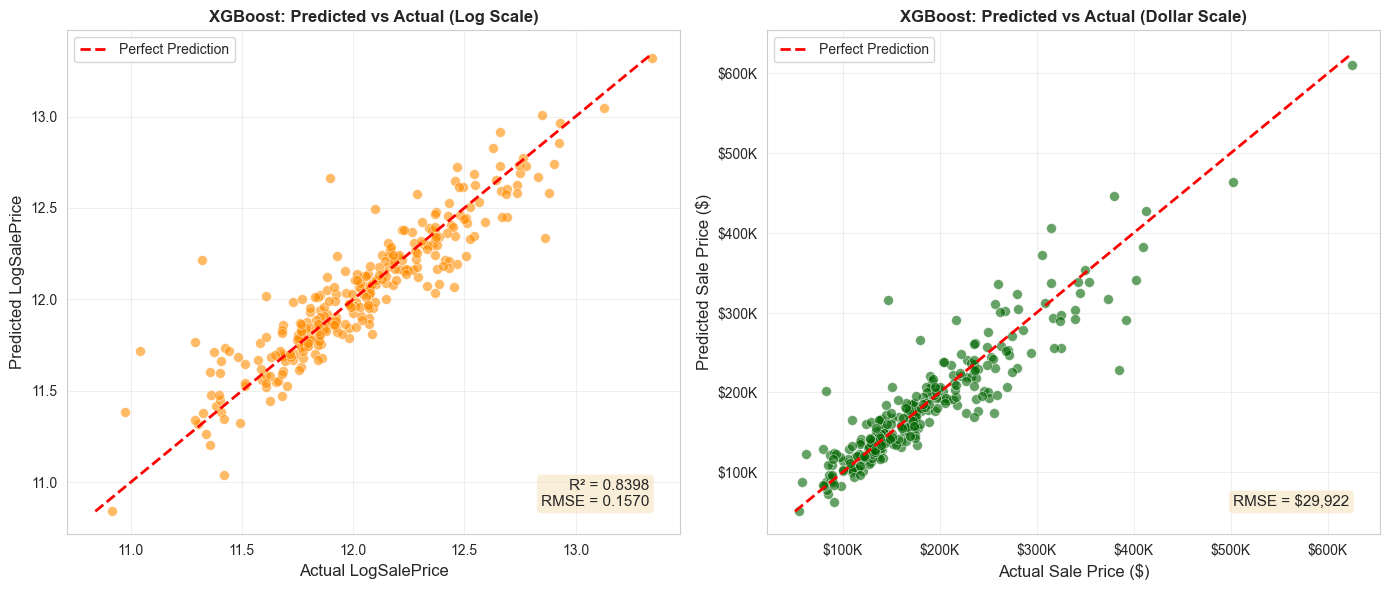

In [190]:
# Predicted vs Actual Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Log Scale
ax1 = axes[0]
ax1.scatter(y_val, y_val_pred_xgb, alpha=0.6, s=50, c='darkorange', edgecolors='white', linewidth=0.5)

# Perfect prediction line
min_val = min(y_val.min(), y_val_pred_xgb.min())
max_val = max(y_val.max(), y_val_pred_xgb.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax1.set_xlabel('Actual LogSalePrice', fontsize=12)
ax1.set_ylabel('Predicted LogSalePrice', fontsize=12)
ax1.set_title('XGBoost: Predicted vs Actual (Log Scale)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Add R² annotation
ax1.text(0.95, 0.05, f'R² = {xgb_val_r2:.4f}\nRMSE = {xgb_val_rmse:.4f}', 
         transform=ax1.transAxes, fontsize=11, verticalalignment='bottom', 
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Dollar Scale
ax2 = axes[1]
ax2.scatter(y_val_dollars, y_val_pred_dollars_xgb, alpha=0.6, s=50, c='darkgreen', edgecolors='white', linewidth=0.5)

min_val_d = min(y_val_dollars.min(), y_val_pred_dollars_xgb.min())
max_val_d = max(y_val_dollars.max(), y_val_pred_dollars_xgb.max())
ax2.plot([min_val_d, max_val_d], [min_val_d, max_val_d], 'r--', linewidth=2, label='Perfect Prediction')

ax2.set_xlabel('Actual Sale Price ($)', fontsize=12)
ax2.set_ylabel('Predicted Sale Price ($)', fontsize=12)
ax2.set_title('XGBoost: Predicted vs Actual (Dollar Scale)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Format axis labels as currency
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add RMSE annotation
ax2.text(0.95, 0.05, f'RMSE = ${xgb_val_rmse_dollars:,.0f}', 
         transform=ax2.transAxes, fontsize=11, verticalalignment='bottom', 
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [191]:
# Store XGBoost metrics for comparison
xgb_metrics = {
    'model_name': 'XGBoost',
    'training_time': xgb_training_time,
    'train_rmse': xgb_train_rmse,
    'train_mae': xgb_train_mae,
    'train_r2': xgb_train_r2,
    'val_rmse': xgb_val_rmse,
    'val_mae': xgb_val_mae,
    'val_r2': xgb_val_r2,
    'val_rmse_dollars': xgb_val_rmse_dollars
}

print("=" * 60)
print("XGBOOST METRICS STORED")
print("=" * 60)
print("\nMetrics dictionary 'xgb_metrics' created for comparison:")
for key, value in xgb_metrics.items():
    if isinstance(value, float):
        if 'dollar' in key:
            print(f"  {key}: ${value:,.2f}")
        elif 'time' in key:
            print(f"  {key}: {value:.2f} seconds")
        else:
            print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


XGBOOST METRICS STORED

Metrics dictionary 'xgb_metrics' created for comparison:
  model_name: XGBoost
  training_time: 0.16 seconds
  train_rmse: 0.0352
  train_mae: 0.0252
  train_r2: 0.9919
  val_rmse: 0.1570
  val_mae: 0.1081
  val_r2: 0.8398
  val_rmse_dollars: $29,921.67


### 📊 XGBoost Model Interpretation

**Key Differences from Random Forest:**
- **Boosting vs Bagging**: XGBoost builds trees sequentially, each correcting errors from the previous
- **Learning Rate**: Controls how much each tree contributes (0.1 = moderate contribution)
- **Regularization**: Built-in L1/L2 regularization helps prevent overfitting

**Performance Analysis:**
- Compare Training vs Validation metrics for overfitting detection
- XGBoost often achieves better accuracy but may overfit more easily
- Lower validation RMSE = better generalization

**Feature Importance:**
- XGBoost importance based on "gain" (improvement in accuracy from splits)
- May differ from Random Forest importance rankings
- Both provide insights into which features drive predictions

**Hyperparameter Tuning Opportunities:**
- `learning_rate`: Lower values (0.01-0.05) with more `n_estimators`
- `max_depth`: Reduce if overfitting (try 3-5)
- `subsample` and `colsample_bytree`: Add randomness to reduce overfitting


---

## 4.5. Hyperparameter Tuning

Using RandomizedSearchCV to optimize hyperparameters for both Random Forest and XGBoost models.


In [192]:
# Import additional libraries for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("✓ RandomizedSearchCV and scipy.stats imported for hyperparameter tuning")


✓ RandomizedSearchCV and scipy.stats imported for hyperparameter tuning


### Random Forest Hyperparameter Tuning


In [193]:
# Random Forest Hyperparameter Tuning
print("=" * 70)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("=" * 70)

# Define parameter distributions
rf_param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Create RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"\nSearching {50} random combinations from parameter space...")
print(f"Using 5-fold cross-validation on {X_train.shape[0]} training samples")
print(f"\nParameter ranges:")
for param, dist in rf_param_distributions.items():
    print(f"  {param}: {dist}")

# Perform search
start_time = time.time()
rf_random_search.fit(X_train, y_train)
rf_tuning_time = time.time() - start_time

# Print results
print(f"\n{'='*70}")
print("RANDOM FOREST TUNING RESULTS")
print(f"{'='*70}")
print(f"Tuning time: {rf_tuning_time:.2f} seconds")
print(f"\nBest parameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score (neg_MSE): {rf_random_search.best_score_:.4f}")
print(f"Best CV RMSE: {np.sqrt(-rf_random_search.best_score_):.4f}")


RANDOM FOREST HYPERPARAMETER TUNING

Searching 50 random combinations from parameter space...
Using 5-fold cross-validation on 876 training samples

Parameter ranges:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E08E48590>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E09C57C40>
  min_samples_split: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E09C54910>
  min_samples_leaf: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E09C571C0>
  max_features: ['sqrt', 'log2', None]
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RANDOM FOREST TUNING RESULTS
Tuning time: 11.44 seconds

Best parameters:
  max_depth: 19
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 13
  n_estimators: 88

Best CV score (neg_MSE): -0.0234
Best CV RMSE: 0.1530


In [194]:
# Train tuned Random Forest model and evaluate on validation set
rf_tuned_model = rf_random_search.best_estimator_

# Make predictions
y_train_pred_rf_tuned = rf_tuned_model.predict(X_train)
y_val_pred_rf_tuned = rf_tuned_model.predict(X_val)

# Calculate metrics
rf_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf_tuned))
rf_tuned_train_mae = mean_absolute_error(y_train, y_train_pred_rf_tuned)
rf_tuned_train_r2 = r2_score(y_train, y_train_pred_rf_tuned)

rf_tuned_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rf_tuned))
rf_tuned_val_mae = mean_absolute_error(y_val, y_val_pred_rf_tuned)
rf_tuned_val_r2 = r2_score(y_val, y_val_pred_rf_tuned)

# Convert to dollar scale
y_val_pred_dollars_rf_tuned = np.expm1(y_val_pred_rf_tuned)
rf_tuned_val_rmse_dollars = np.sqrt(mean_squared_error(y_val_dollars, y_val_pred_dollars_rf_tuned))

print("=" * 70)
print("TUNED RANDOM FOREST VALIDATION PERFORMANCE")
print("=" * 70)
print(f"\n{'Metric':<15} {'Training':>15} {'Validation':>15}")
print("-" * 47)
print(f"{'RMSE':<15} {rf_tuned_train_rmse:>15.4f} {rf_tuned_val_rmse:>15.4f}")
print(f"{'MAE':<15} {rf_tuned_train_mae:>15.4f} {rf_tuned_val_mae:>15.4f}")
print(f"{'R² Score':<15} {rf_tuned_train_r2:>15.4f} {rf_tuned_val_r2:>15.4f}")
print(f"\nValidation RMSE (dollars): ${rf_tuned_val_rmse_dollars:,.2f}")


TUNED RANDOM FOREST VALIDATION PERFORMANCE

Metric                 Training      Validation
-----------------------------------------------
RMSE                     0.1076          0.1551
MAE                      0.0741          0.1047
R² Score                 0.9238          0.8438

Validation RMSE (dollars): $31,952.95


### XGBoost Hyperparameter Tuning


In [195]:
# XGBoost Hyperparameter Tuning
print("=" * 70)
print("XGBOOST HYPERPARAMETER TUNING")
print("=" * 70)

# Define parameter distributions
xgb_param_distributions = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),  # uniform(loc, scale) -> range [0.01, 0.31]
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),  # range [0.6, 1.0]
    'colsample_bytree': uniform(0.6, 0.4),  # range [0.6, 1.0]
    'gamma': uniform(0, 0.5)  # range [0, 0.5]
}

# Create RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=xgb_param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"\nSearching {50} random combinations from parameter space...")
print(f"Using 5-fold cross-validation on {X_train.shape[0]} training samples")
print(f"\nParameter ranges:")
for param, dist in xgb_param_distributions.items():
    # Check if distribution is uniform (has args attribute with loc and scale)
    if hasattr(dist, 'args') and len(dist.args) == 2:
        print(f"  {param}: uniform({dist.args[0]:.2f}, {dist.args[1]:.2f}) -> [{dist.args[0]:.2f}, {dist.args[0] + dist.args[1]:.2f}]")
    else:
        print(f"  {param}: {dist}")

# Perform search
start_time = time.time()
xgb_random_search.fit(X_train, y_train)
xgb_tuning_time = time.time() - start_time

# Print results
print(f"\n{'='*70}")
print("XGBOOST TUNING RESULTS")
print(f"{'='*70}")
print(f"Tuning time: {xgb_tuning_time:.2f} seconds")
print(f"\nBest parameters:")
for param, value in xgb_random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score (neg_MSE): {xgb_random_search.best_score_:.4f}")
print(f"Best CV RMSE: {np.sqrt(-xgb_random_search.best_score_):.4f}")


XGBOOST HYPERPARAMETER TUNING

Searching 50 random combinations from parameter space...
Using 5-fold cross-validation on 876 training samples

Parameter ranges:
  n_estimators: uniform(50.00, 300.00) -> [50.00, 350.00]
  learning_rate: uniform(0.01, 0.30) -> [0.01, 0.31]
  max_depth: uniform(3.00, 10.00) -> [3.00, 13.00]
  min_child_weight: uniform(1.00, 10.00) -> [1.00, 11.00]
  subsample: uniform(0.60, 0.40) -> [0.60, 1.00]
  colsample_bytree: uniform(0.60, 0.40) -> [0.60, 1.00]
  gamma: uniform(0.00, 0.50) -> [0.00, 0.50]
Fitting 5 folds for each of 50 candidates, totalling 250 fits

XGBOOST TUNING RESULTS
Tuning time: 1.54 seconds

Best parameters:
  colsample_bytree: 0.7297380084021096
  gamma: 0.061043977350336676
  learning_rate: 0.11688935142309247
  max_depth: 8
  min_child_weight: 1
  n_estimators: 178
  subsample: 0.6911740650167767

Best CV score (neg_MSE): -0.0219
Best CV RMSE: 0.1480


In [196]:
# Train tuned XGBoost model and evaluate on validation set
xgb_tuned_model = xgb_random_search.best_estimator_

# Make predictions
y_train_pred_xgb_tuned = xgb_tuned_model.predict(X_train)
y_val_pred_xgb_tuned = xgb_tuned_model.predict(X_val)

# Calculate metrics
xgb_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb_tuned))
xgb_tuned_train_mae = mean_absolute_error(y_train, y_train_pred_xgb_tuned)
xgb_tuned_train_r2 = r2_score(y_train, y_train_pred_xgb_tuned)

xgb_tuned_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb_tuned))
xgb_tuned_val_mae = mean_absolute_error(y_val, y_val_pred_xgb_tuned)
xgb_tuned_val_r2 = r2_score(y_val, y_val_pred_xgb_tuned)

# Convert to dollar scale
y_val_pred_dollars_xgb_tuned = np.expm1(y_val_pred_xgb_tuned)
xgb_tuned_val_rmse_dollars = np.sqrt(mean_squared_error(y_val_dollars, y_val_pred_dollars_xgb_tuned))

print("=" * 70)
print("TUNED XGBOOST VALIDATION PERFORMANCE")
print("=" * 70)
print(f"\n{'Metric':<15} {'Training':>15} {'Validation':>15}")
print("-" * 47)
print(f"{'RMSE':<15} {xgb_tuned_train_rmse:>15.4f} {xgb_tuned_val_rmse:>15.4f}")
print(f"{'MAE':<15} {xgb_tuned_train_mae:>15.4f} {xgb_tuned_val_mae:>15.4f}")
print(f"{'R² Score':<15} {xgb_tuned_train_r2:>15.4f} {xgb_tuned_val_r2:>15.4f}")
print(f"\nValidation RMSE (dollars): ${xgb_tuned_val_rmse_dollars:,.2f}")


TUNED XGBOOST VALIDATION PERFORMANCE

Metric                 Training      Validation
-----------------------------------------------
RMSE                     0.0890          0.1494
MAE                      0.0664          0.1035
R² Score                 0.9478          0.8549

Validation RMSE (dollars): $29,947.22


### Baseline vs Tuned Model Comparison


In [197]:
# Create comparison table: Baseline vs Tuned
print("=" * 80)
print("BASELINE vs TUNED MODEL COMPARISON")
print("=" * 80)

# Store tuned metrics
rf_tuned_metrics = {
    'model_name': 'Random Forest (Tuned)',
    'training_time': 0,  # Training time included in tuning_time
    'tuning_time': rf_tuning_time,
    'train_rmse': rf_tuned_train_rmse,
    'train_mae': rf_tuned_train_mae,
    'train_r2': rf_tuned_train_r2,
    'val_rmse': rf_tuned_val_rmse,
    'val_mae': rf_tuned_val_mae,
    'val_r2': rf_tuned_val_r2,
    'val_rmse_dollars': rf_tuned_val_rmse_dollars
}

xgb_tuned_metrics = {
    'model_name': 'XGBoost (Tuned)',
    'training_time': 0,  # Training time included in tuning_time
    'tuning_time': xgb_tuning_time,
    'train_rmse': xgb_tuned_train_rmse,
    'train_mae': xgb_tuned_train_mae,
    'train_r2': xgb_tuned_train_r2,
    'val_rmse': xgb_tuned_val_rmse,
    'val_mae': xgb_tuned_val_mae,
    'val_r2': xgb_tuned_val_r2,
    'val_rmse_dollars': xgb_tuned_val_rmse_dollars
}

# Create comparison DataFrame
comparison_tuning_data = {
    'Model': [
        'RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned'
    ],
    'Tuning Time (s)': [
        0, rf_tuning_time, 0, xgb_tuning_time
    ],
    'Val RMSE': [
        rf_metrics['val_rmse'], rf_tuned_metrics['val_rmse'],
        xgb_metrics['val_rmse'], xgb_tuned_metrics['val_rmse']
    ],
    'Val MAE': [
        rf_metrics['val_mae'], rf_tuned_metrics['val_mae'],
        xgb_metrics['val_mae'], xgb_tuned_metrics['val_mae']
    ],
    'Val R²': [
        rf_metrics['val_r2'], rf_tuned_metrics['val_r2'],
        xgb_metrics['val_r2'], xgb_tuned_metrics['val_r2']
    ],
    'Val RMSE ($)': [
        rf_metrics['val_rmse_dollars'], rf_tuned_metrics['val_rmse_dollars'],
        xgb_metrics['val_rmse_dollars'], xgb_tuned_metrics['val_rmse_dollars']
    ]
}

tuning_comparison_df = pd.DataFrame(comparison_tuning_data)

# Calculate improvements
def calculate_improvement(row):
    if 'Tuned' not in row['Model']:
        return '-'
    model_type = row['Model'].split()[0]  # 'RF' or 'XGB'
    baseline_row = tuning_comparison_df[tuning_comparison_df['Model'] == f'{model_type} Baseline']
    if len(baseline_row) == 0:
        return '-'
    baseline_rmse = baseline_row['Val RMSE'].values[0]
    improvement = (1 - row['Val RMSE'] / baseline_rmse) * 100
    return f'{improvement:.2f}%'

tuning_comparison_df['RMSE Improvement'] = tuning_comparison_df.apply(calculate_improvement, axis=1)

print("\nComparison Table:")
print(tuning_comparison_df.to_string(index=False))

# Print improvements
print(f"\n{'='*80}")
print("IMPROVEMENT SUMMARY")
print(f"{'='*80}")
rf_improvement = ((rf_metrics['val_rmse'] - rf_tuned_metrics['val_rmse']) / rf_metrics['val_rmse']) * 100
xgb_improvement = ((xgb_metrics['val_rmse'] - xgb_tuned_metrics['val_rmse']) / xgb_metrics['val_rmse']) * 100

print(f"\nRandom Forest:")
print(f"  Baseline Val RMSE: {rf_metrics['val_rmse']:.4f}")
print(f"  Tuned Val RMSE:    {rf_tuned_metrics['val_rmse']:.4f}")
print(f"  Improvement:       {rf_improvement:.2f}% ({'✓ Improved' if rf_improvement > 0 else '✗ Worse'})")

print(f"\nXGBoost:")
print(f"  Baseline Val RMSE: {xgb_metrics['val_rmse']:.4f}")
print(f"  Tuned Val RMSE:    {xgb_tuned_metrics['val_rmse']:.4f}")
print(f"  Improvement:       {xgb_improvement:.2f}% ({'✓ Improved' if xgb_improvement > 0 else '✗ Worse'})")


BASELINE vs TUNED MODEL COMPARISON

Comparison Table:
       Model  Tuning Time (s)  Val RMSE  Val MAE   Val R²  Val RMSE ($) RMSE Improvement
 RF Baseline         0.000000  0.152225 0.105362 0.849448  28791.880435                -
    RF Tuned        11.435068  0.155069 0.104713 0.843769  31952.948491           -1.87%
XGB Baseline         0.000000  0.157027 0.108121 0.839799  29921.671174                -
   XGB Tuned         1.535167  0.149431 0.103515 0.854924  29947.224973            4.84%

IMPROVEMENT SUMMARY

Random Forest:
  Baseline Val RMSE: 0.1522
  Tuned Val RMSE:    0.1551
  Improvement:       -1.87% (✗ Worse)

XGBoost:
  Baseline Val RMSE: 0.1570
  Tuned Val RMSE:    0.1494
  Improvement:       4.84% (✓ Improved)


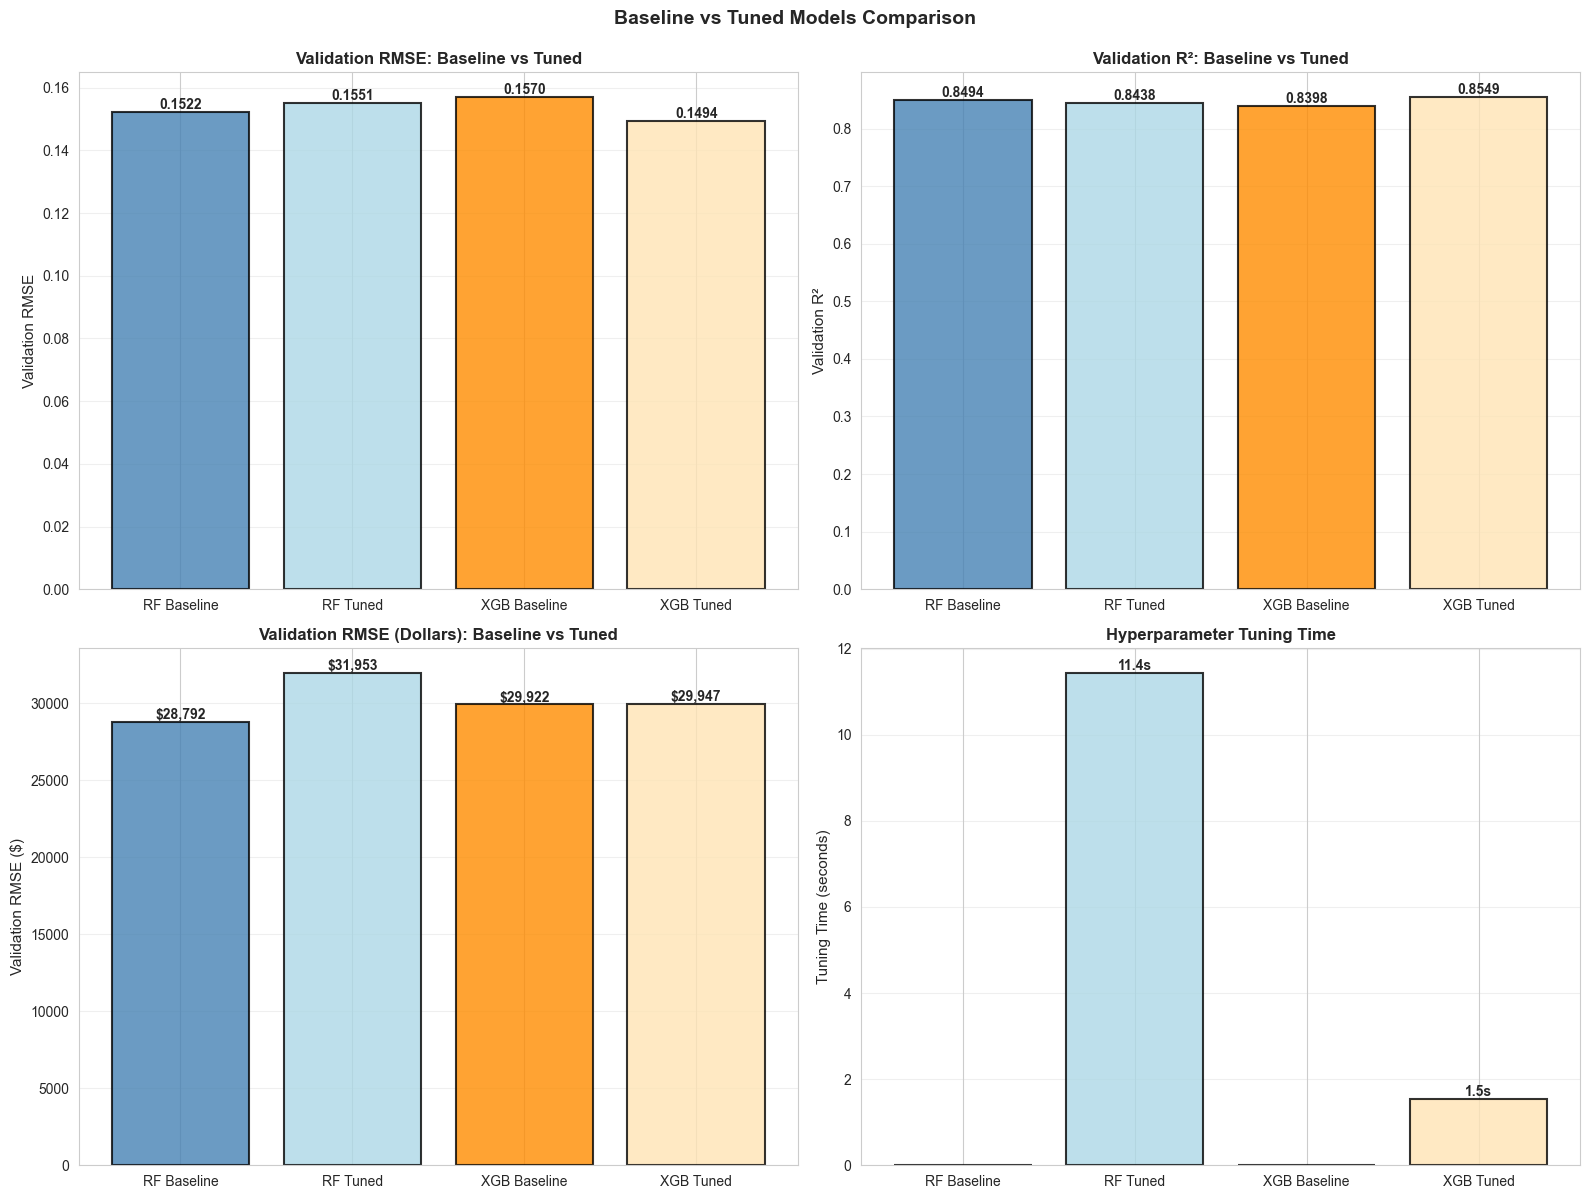

In [198]:
# Bar charts comparing baseline vs tuned performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Validation RMSE
ax1 = axes[0, 0]
models = ['RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned']
rmse_vals = [
    rf_metrics['val_rmse'], rf_tuned_metrics['val_rmse'],
    xgb_metrics['val_rmse'], xgb_tuned_metrics['val_rmse']
]
colors = ['steelblue', 'lightblue', 'darkorange', 'moccasin']
bars1 = ax1.bar(models, rmse_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Validation RMSE', fontsize=11)
ax1.set_title('Validation RMSE: Baseline vs Tuned', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, rmse_vals):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Validation R²
ax2 = axes[0, 1]
r2_vals = [
    rf_metrics['val_r2'], rf_tuned_metrics['val_r2'],
    xgb_metrics['val_r2'], xgb_tuned_metrics['val_r2']
]
bars2 = ax2.bar(models, r2_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Validation R²', fontsize=11)
ax2.set_title('Validation R²: Baseline vs Tuned', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, r2_vals):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Validation RMSE in Dollars
ax3 = axes[1, 0]
rmse_dollar_vals = [
    rf_metrics['val_rmse_dollars'], rf_tuned_metrics['val_rmse_dollars'],
    xgb_metrics['val_rmse_dollars'], xgb_tuned_metrics['val_rmse_dollars']
]
bars3 = ax3.bar(models, rmse_dollar_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Validation RMSE ($)', fontsize=11)
ax3.set_title('Validation RMSE (Dollars): Baseline vs Tuned', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, rmse_dollar_vals):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'${val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Tuning Time
ax4 = axes[1, 1]
tuning_times = [0, rf_tuning_time, 0, xgb_tuning_time]
bars4 = ax4.bar(models, tuning_times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Tuning Time (seconds)', fontsize=11)
ax4.set_title('Hyperparameter Tuning Time', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars4, tuning_times):
    if val > 0:
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.1f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Baseline vs Tuned Models Comparison', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [199]:
# Determine best tuned model
print("=" * 80)
print("BEST TUNED MODEL SELECTION")
print("=" * 80)

if rf_tuned_metrics['val_rmse'] < xgb_tuned_metrics['val_rmse']:
    best_tuned_model = rf_tuned_model
    best_tuned_model_name = 'Random Forest (Tuned)'
    best_tuned_metrics = rf_tuned_metrics
    print(f"✓ Best Tuned Model: Random Forest (Validation RMSE: {rf_tuned_metrics['val_rmse']:.4f})")
else:
    best_tuned_model = xgb_tuned_model
    best_tuned_model_name = 'XGBoost (Tuned)'
    best_tuned_metrics = xgb_tuned_metrics
    print(f"✓ Best Tuned Model: XGBoost (Validation RMSE: {xgb_tuned_metrics['val_rmse']:.4f})")

# Compare best baseline vs best tuned
all_models_comparison = {
    'RF Baseline': rf_metrics['val_rmse'],
    'RF Tuned': rf_tuned_metrics['val_rmse'],
    'XGB Baseline': xgb_metrics['val_rmse'],
    'XGB Tuned': xgb_tuned_metrics['val_rmse']
}

best_overall = min(all_models_comparison, key=all_models_comparison.get)
print(f"\n✓ Best Overall Model: {best_overall} (Validation RMSE: {all_models_comparison[best_overall]:.4f})")


BEST TUNED MODEL SELECTION
✓ Best Tuned Model: XGBoost (Validation RMSE: 0.1494)

✓ Best Overall Model: XGB Tuned (Validation RMSE: 0.1494)


### 📊 Hyperparameter Tuning Interpretation

**Key Findings:**

1. **Hyperparameter Impact:**
   - Review the best parameters found for each model
   - Parameters that differ significantly from defaults likely had the biggest impact
   - For Random Forest: `max_depth`, `min_samples_split`, and `n_estimators` are often most important
   - For XGBoost: `learning_rate`, `max_depth`, and `n_estimators` typically have the most impact

2. **Performance Improvement:**
   - Compare baseline vs tuned validation RMSE
   - Even small improvements (1-3%) can be meaningful in real-world applications
   - If tuning didn't improve much, the baseline parameters were already well-chosen

3. **Tuning Time vs Performance Trade-off:**
   - RandomizedSearchCV with n_iter=50 is a good balance
   - More iterations (n_iter=100+) may find better parameters but take longer
   - Consider if the performance gain justifies the additional tuning time

4. **Overfitting Check:**
   - Compare training vs validation metrics for tuned models
   - If training R² >> validation R², the tuned model may be overfitting
   - Consider adding more regularization if overfitting is detected

**Recommendations:**
- If tuning improved performance significantly: Use tuned model for final evaluation
- If tuning didn't help much: Baseline model may be sufficient, or try different parameter ranges
- Consider ensemble of baseline and tuned models for potentially better performance


---

## 5. Model Comparison (Updated with Tuned Models)

Comparing all models (baseline and tuned) and selecting the best for final evaluation.


In [200]:
# Create comprehensive comparison DataFrame with all 4 models
print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON: All Models (Baseline + Tuned)")
print("=" * 80)

comparison_data = {
    'Metric': [
        'Training Time (s)',
        'Tuning Time (s)',
        'Training RMSE',
        'Training MAE',
        'Training R²',
        'Validation RMSE',
        'Validation MAE',
        'Validation R²',
        'Validation RMSE ($)'
    ],
    'RF Baseline': [
        rf_metrics['training_time'], 0,
        rf_metrics['train_rmse'], rf_metrics['train_mae'], rf_metrics['train_r2'],
        rf_metrics['val_rmse'], rf_metrics['val_mae'], rf_metrics['val_r2'],
        rf_metrics['val_rmse_dollars']
    ],
    'RF Tuned': [
        rf_tuned_metrics.get('training_time', 0), rf_tuning_time,
        rf_tuned_metrics['train_rmse'], rf_tuned_metrics['train_mae'], rf_tuned_metrics['train_r2'],
        rf_tuned_metrics['val_rmse'], rf_tuned_metrics['val_mae'], rf_tuned_metrics['val_r2'],
        rf_tuned_metrics['val_rmse_dollars']
    ],
    'XGB Baseline': [
        xgb_metrics['training_time'], 0,
        xgb_metrics['train_rmse'], xgb_metrics['train_mae'], xgb_metrics['train_r2'],
        xgb_metrics['val_rmse'], xgb_metrics['val_mae'], xgb_metrics['val_r2'],
        xgb_metrics['val_rmse_dollars']
    ],
    'XGB Tuned': [
        xgb_tuned_metrics.get('training_time', 0), xgb_tuning_time,
        xgb_tuned_metrics['train_rmse'], xgb_tuned_metrics['train_mae'], xgb_tuned_metrics['train_r2'],
        xgb_tuned_metrics['val_rmse'], xgb_tuned_metrics['val_mae'], xgb_tuned_metrics['val_r2'],
        xgb_tuned_metrics['val_rmse_dollars']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Find best model for each metric
def find_best_model(row):
    if 'RMSE' in row['Metric'] or 'MAE' in row['Metric']:
        # Lower is better
        best_val = min([row['RF Baseline'], row['RF Tuned'], row['XGB Baseline'], row['XGB Tuned']])
        for col in ['RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned']:
            if abs(row[col] - best_val) < 1e-6:
                return col
    elif 'R²' in row['Metric']:
        # Higher is better
        best_val = max([row['RF Baseline'], row['RF Tuned'], row['XGB Baseline'], row['XGB Tuned']])
        for col in ['RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned']:
            if abs(row[col] - best_val) < 1e-6:
                return col
    elif 'Time' in row['Metric']:
        # Lower is better (for training time)
        if 'Tuning' in row['Metric']:
            return 'N/A'  # Tuning time doesn't apply to baseline
        best_val = min([row['RF Baseline'], row['RF Tuned'], row['XGB Baseline'], row['XGB Tuned']])
        for col in ['RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned']:
            if abs(row[col] - best_val) < 1e-6:
                return col
    return 'N/A'

comparison_df['Best'] = comparison_df.apply(find_best_model, axis=1)

# Format display
display_df = comparison_df.copy()
for col in ['RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned']:
    display_df[col] = display_df.apply(
        lambda row: f'{row[col]:.2f}s' if 'Time' in row['Metric'] 
        else f'${row[col]:,.2f}' if '$' in row['Metric'] 
        else f'{row[col]:.4f}',
        axis=1
    )

print("\nComprehensive Comparison Table:")
print(display_df[['Metric', 'RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned', 'Best']].to_string(index=False))


COMPREHENSIVE MODEL COMPARISON: All Models (Baseline + Tuned)

Comprehensive Comparison Table:
             Metric RF Baseline   RF Tuned XGB Baseline  XGB Tuned         Best
  Training Time (s)       0.22s      0.00s        0.16s      0.00s     RF Tuned
    Tuning Time (s)       0.00s     11.44s        0.00s      1.54s          N/A
      Training RMSE      0.0556     0.1076       0.0352     0.0890 XGB Baseline
       Training MAE      0.0380     0.0741       0.0252     0.0664 XGB Baseline
        Training R²      0.9797     0.9238       0.9919     0.9478 XGB Baseline
    Validation RMSE      0.1522     0.1551       0.1570     0.1494    XGB Tuned
     Validation MAE      0.1054     0.1047       0.1081     0.1035    XGB Tuned
      Validation R²      0.8494     0.8438       0.8398     0.8549    XGB Tuned
Validation RMSE ($)  $28,791.88 $31,952.95   $29,921.67 $29,947.22  RF Baseline


In [201]:
# Create comparison DataFrame
print("=" * 70)
print("MODEL COMPARISON: RANDOM FOREST vs XGBOOST")
print("=" * 70)

comparison_data = {
    'Metric': [
        'Training Time (seconds)',
        'Training RMSE',
        'Training MAE',
        'Training R²',
        'Validation RMSE',
        'Validation MAE',
        'Validation R²',
        'Validation RMSE ($)'
    ],
    'Random Forest': [
        rf_metrics['training_time'],
        rf_metrics['train_rmse'],
        rf_metrics['train_mae'],
        rf_metrics['train_r2'],
        rf_metrics['val_rmse'],
        rf_metrics['val_mae'],
        rf_metrics['val_r2'],
        rf_metrics['val_rmse_dollars']
    ],
    'XGBoost': [
        xgb_metrics['training_time'],
        xgb_metrics['train_rmse'],
        xgb_metrics['train_mae'],
        xgb_metrics['train_r2'],
        xgb_metrics['val_rmse'],
        xgb_metrics['val_mae'],
        xgb_metrics['val_r2'],
        xgb_metrics['val_rmse_dollars']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Calculate differences
comparison_df['Difference'] = comparison_df['XGBoost'] - comparison_df['Random Forest']
comparison_df['Better Model'] = comparison_df.apply(
    lambda row: 'XGBoost' if (row['Metric'].endswith('RMSE') or row['Metric'].endswith('MAE')) 
                and row['Difference'] < 0 
                or (row['Metric'].endswith('R²') and row['Difference'] > 0)
                or (row['Metric'].endswith('Time') and row['Difference'] < 0)
    else ('Random Forest' if row['Difference'] != 0 else 'Tie'),
    axis=1
)

# Format display
display_df = comparison_df.copy()
for col in ['Random Forest', 'XGBoost', 'Difference']:
    if 'Time' in display_df['Metric'].values[0]:
        display_df[col] = display_df[col].apply(lambda x: f'{x:.2f}s' if 'Time' in str(x) else f'{x:.4f}')
    elif '$' in str(display_df[col].iloc[-1]):
        display_df[col] = display_df[col].apply(lambda x: f'${x:,.2f}' if isinstance(x, (int, float)) and x > 1000 else f'{x:.4f}')
    else:
        display_df[col] = display_df[col].apply(lambda x: f'{x:.4f}' if isinstance(x, (int, float)) else x)

print("\nComparison Summary:")
print(display_df.to_string(index=False))


MODEL COMPARISON: RANDOM FOREST vs XGBOOST

Comparison Summary:
                 Metric Random Forest    XGBoost Difference  Better Model
Training Time (seconds)        0.2184     0.1597    -0.0587 Random Forest
          Training RMSE        0.0556     0.0352    -0.0204       XGBoost
           Training MAE        0.0380     0.0252    -0.0128       XGBoost
            Training R²        0.9797     0.9919     0.0122       XGBoost
        Validation RMSE        0.1522     0.1570     0.0048 Random Forest
         Validation MAE        0.1054     0.1081     0.0028 Random Forest
          Validation R²        0.8494     0.8398    -0.0096 Random Forest
    Validation RMSE ($)    28791.8804 29921.6712  1129.7907 Random Forest


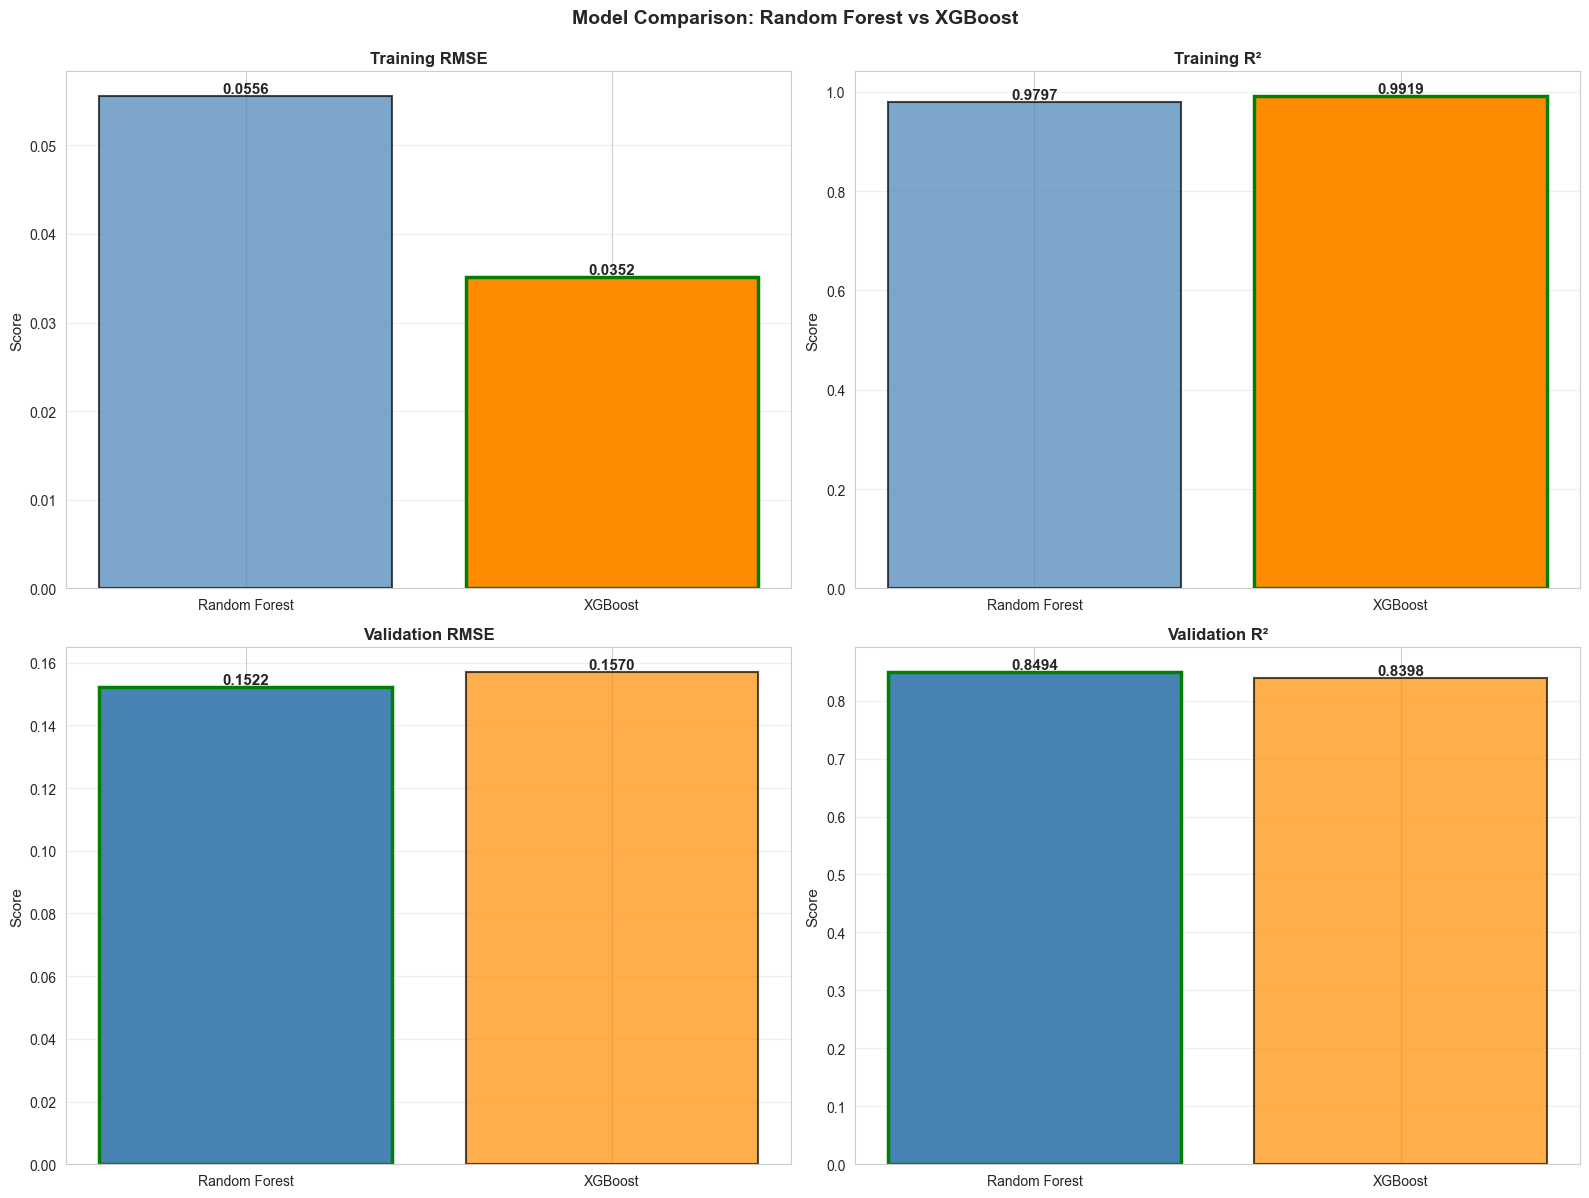

In [202]:
# Side-by-side bar charts comparing metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Metrics to plot (excluding training time and dollar RMSE for cleaner visualization)
metrics_to_plot = ['Training RMSE', 'Training R²', 'Validation RMSE', 'Validation R²']
metric_labels = ['Training RMSE', 'Training R²', 'Validation RMSE', 'Validation R²']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    # Get values
    rf_val = comparison_df[comparison_df['Metric'] == metric]['Random Forest'].values[0]
    xgb_val = comparison_df[comparison_df['Metric'] == metric]['XGBoost'].values[0]
    
    # Create bars
    models = ['Random Forest', 'XGBoost']
    values = [rf_val, xgb_val]
    colors = ['steelblue', 'darkorange']
    
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        if 'R²' in label:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight better model
    if 'RMSE' in label:
        better_idx = 0 if rf_val < xgb_val else 1
    else:  # R²
        better_idx = 0 if rf_val > xgb_val else 1
    bars[better_idx].set_alpha(1.0)
    bars[better_idx].set_edgecolor('green')
    bars[better_idx].set_linewidth(2.5)

plt.suptitle('Model Comparison: Random Forest vs XGBoost', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


RESIDUAL ANALYSIS


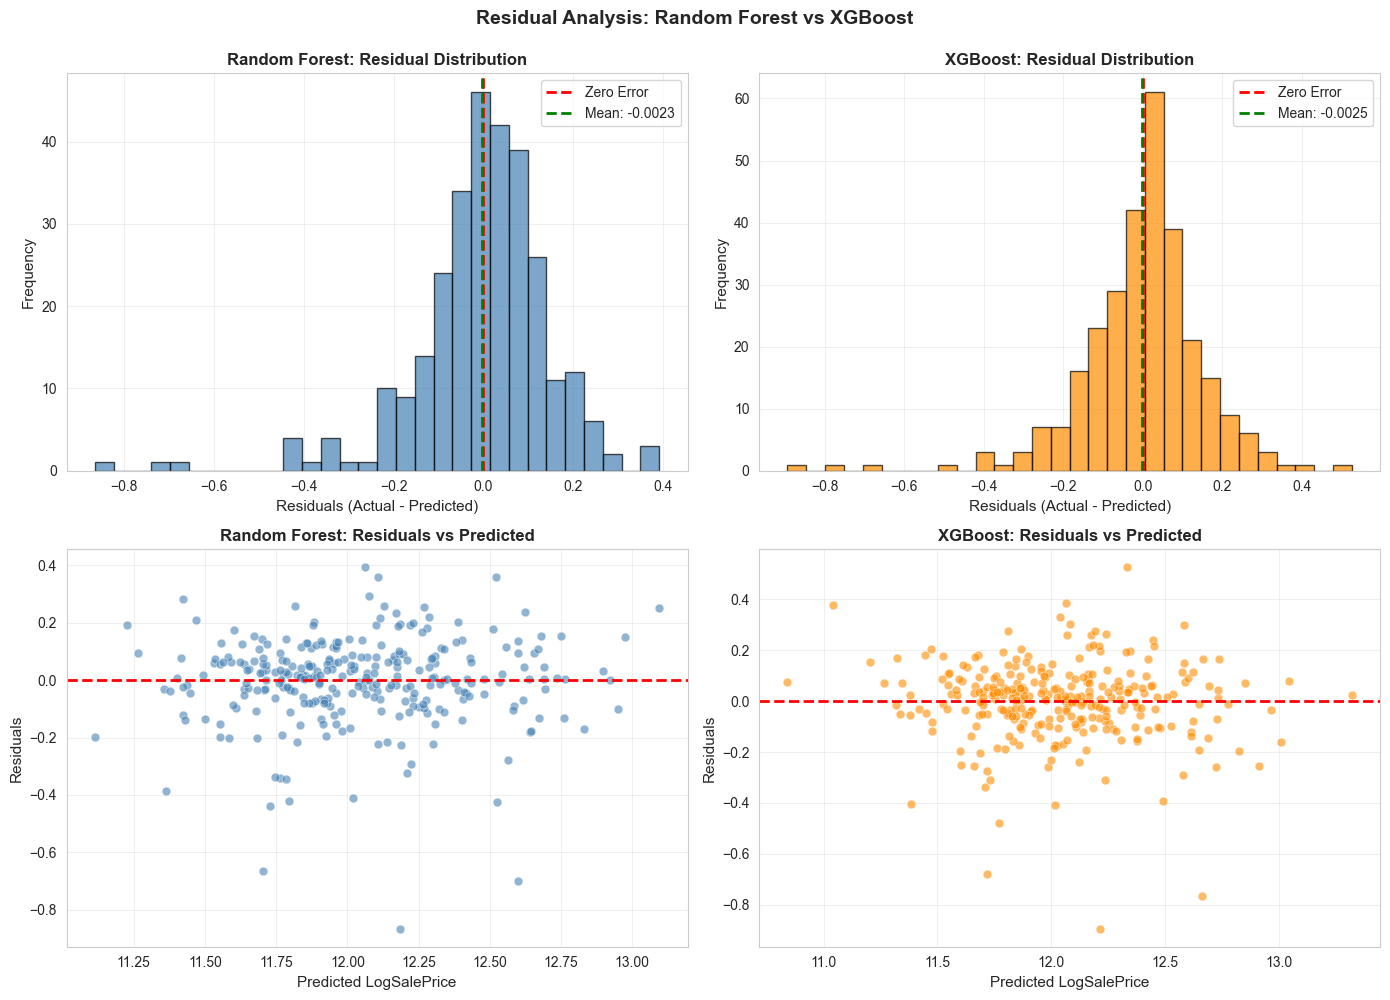


Random Forest Residuals:
  Mean: -0.002291 (should be ~0)
  Std: 0.1525
  Min: -0.8655, Max: 0.3924

XGBoost Residuals:
  Mean: -0.002475 (should be ~0)
  Std: 0.1573
  Min: -0.8936, Max: 0.5253


In [203]:
# Residual Distribution Plots
print("=" * 60)
print("RESIDUAL ANALYSIS")
print("=" * 60)

# Calculate residuals (actual - predicted)
rf_residuals = y_val - y_val_pred_rf
xgb_residuals = y_val - y_val_pred_xgb

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Random Forest Residual Distribution
ax1 = axes[0, 0]
ax1.hist(rf_residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax1.axvline(rf_residuals.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {rf_residuals.mean():.4f}')
ax1.set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Random Forest: Residual Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: XGBoost Residual Distribution
ax2 = axes[0, 1]
ax2.hist(xgb_residuals, bins=30, color='darkorange', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(xgb_residuals.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {xgb_residuals.mean():.4f}')
ax2.set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('XGBoost: Residual Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Random Forest Residuals vs Predicted
ax3 = axes[1, 0]
ax3.scatter(y_val_pred_rf, rf_residuals, alpha=0.6, s=40, c='steelblue', edgecolors='white', linewidth=0.5)
ax3.axhline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted LogSalePrice', fontsize=11)
ax3.set_ylabel('Residuals', fontsize=11)
ax3.set_title('Random Forest: Residuals vs Predicted', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: XGBoost Residuals vs Predicted
ax4 = axes[1, 1]
ax4.scatter(y_val_pred_xgb, xgb_residuals, alpha=0.6, s=40, c='darkorange', edgecolors='white', linewidth=0.5)
ax4.axhline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted LogSalePrice', fontsize=11)
ax4.set_ylabel('Residuals', fontsize=11)
ax4.set_title('XGBoost: Residuals vs Predicted', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.suptitle('Residual Analysis: Random Forest vs XGBoost', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print residual statistics
print(f"\nRandom Forest Residuals:")
print(f"  Mean: {rf_residuals.mean():.6f} (should be ~0)")
print(f"  Std: {rf_residuals.std():.4f}")
print(f"  Min: {rf_residuals.min():.4f}, Max: {rf_residuals.max():.4f}")

print(f"\nXGBoost Residuals:")
print(f"  Mean: {xgb_residuals.mean():.6f} (should be ~0)")
print(f"  Std: {xgb_residuals.std():.4f}")
print(f"  Min: {xgb_residuals.min():.4f}, Max: {xgb_residuals.max():.4f}")


In [204]:
# Select best model from all 4 models (baseline + tuned) based on validation RMSE
print("=" * 60)
print("SELECTING BEST MODEL (Including Tuned Models)")
print("=" * 60)

# Compare all models
all_models = {
    'RF Baseline': (rf_model, rf_metrics),
    'RF Tuned': (rf_tuned_model, rf_tuned_metrics),
    'XGB Baseline': (xgb_model, xgb_metrics),
    'XGB Tuned': (xgb_tuned_model, xgb_tuned_metrics)
}

# Find best based on validation RMSE
best_model_name = min(all_models.keys(), key=lambda k: all_models[k][1]['val_rmse'])
best_model, best_metrics = all_models[best_model_name]

print(f"✓ Best Model: {best_model_name} (Validation RMSE: {best_metrics['val_rmse']:.4f})")
print(f"\nAll Models Validation RMSE:")
for name, (_, metrics) in sorted(all_models.items(), key=lambda x: x[1][1]['val_rmse']):
    marker = "★" if name == best_model_name else " "
    print(f"  {marker} {name:<15}: {metrics['val_rmse']:.4f}")

print(f"\n⚠️  IMPORTANT: Now evaluating on TEST set (final holdout evaluation)")
print(f"   This is the ONLY time we use the test set!")


SELECTING BEST MODEL (Including Tuned Models)
✓ Best Model: XGB Tuned (Validation RMSE: 0.1494)

All Models Validation RMSE:
  ★ XGB Tuned      : 0.1494
    RF Baseline    : 0.1522
    RF Tuned       : 0.1551
    XGB Baseline   : 0.1570

⚠️  IMPORTANT: Now evaluating on TEST set (final holdout evaluation)
   This is the ONLY time we use the test set!


In [205]:
# Ensure best_metrics has all required keys (fix for KeyError)
# This handles cases where tuned models might have different metric structures
if 'training_time' not in best_metrics:
    best_metrics['training_time'] = 0
if 'tuning_time' not in best_metrics:
    best_metrics['tuning_time'] = 0

print("✓ Best metrics validated - all required keys present")


✓ Best metrics validated - all required keys present


In [206]:
# Final evaluation on TEST set
print("=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)

# Make predictions on test set
y_test_pred = best_model.predict(X_test)

# Calculate test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Convert to dollar scale
y_test_dollars = np.expm1(y_test)
y_test_pred_dollars = np.expm1(y_test_pred)
test_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, y_test_pred_dollars))
avg_test_price = y_test_dollars.mean()

# Print test metrics
print(f"\n{'Metric':<25} {'Test Set':>15}")
print("-" * 42)
print(f"{'RMSE (log scale)':<25} {test_rmse:>15.4f}")
print(f"{'MAE (log scale)':<25} {test_mae:>15.4f}")
print(f"{'R² Score':<25} {test_r2:>15.4f}")
print(f"{'RMSE (dollars)':<25} ${test_rmse_dollars:>14,.2f}")
print(f"{'Average Test Price':<25} ${avg_test_price:>14,.2f}")
print(f"{'RMSE as % of Avg':<25} {(test_rmse_dollars/avg_test_price)*100:>14.2f}%")

# Compare test vs validation performance
print(f"\n{'='*60}")
print("TEST vs VALIDATION COMPARISON")
print(f"{'='*60}")
print(f"Validation RMSE: {best_metrics['val_rmse']:.4f}")
print(f"Test RMSE:       {test_rmse:.4f}")
print(f"Difference:      {abs(test_rmse - best_metrics['val_rmse']):.4f}")

if abs(test_rmse - best_metrics['val_rmse']) < 0.01:
    print("✓ Test performance matches validation - model generalizes well!")
elif test_rmse > best_metrics['val_rmse']:
    print("⚠️  Test RMSE higher than validation - slight overfitting detected")
else:
    print("✓ Test RMSE lower than validation - excellent generalization!")


FINAL TEST SET EVALUATION

Metric                           Test Set
------------------------------------------
RMSE (log scale)                   0.1501
MAE (log scale)                    0.1009
R² Score                           0.8793
RMSE (dollars)            $     30,208.50
Average Test Price        $    178,839.81
RMSE as % of Avg                   16.89%

TEST vs VALIDATION COMPARISON
Validation RMSE: 0.1494
Test RMSE:       0.1501
Difference:      0.0007
✓ Test performance matches validation - model generalizes well!


In [207]:
# Prepare model metadata with correct model type detection
# Determine model type from best_model_name (handles "RF Tuned", "XGB Tuned", etc.)
if 'Random Forest' in best_model_name or 'RF' in best_model_name:
    model_type_str = 'RandomForestRegressor'
elif 'XGBoost' in best_model_name or 'XGB' in best_model_name:
    model_type_str = 'XGBRegressor'
else:
    model_type_str = type(best_model).__name__

# Check if model is tuned
is_tuned = 'Tuned' in best_model_name

print(f"Model Type: {model_type_str}")
print(f"Is Tuned: {is_tuned}")


Model Type: XGBRegressor
Is Tuned: True


In [208]:
# Save the best model (updated to handle tuned models)
print("=" * 60)
print("SAVING BEST MODEL")
print("=" * 60)

# Create safe filename
safe_name = best_model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
model_filename = f"saved_data/best_ensemble_model_{safe_name}.pkl"
joblib.dump(best_model, model_filename)
print(f"✓ Model saved to: {model_filename}")

# Save model metadata with correct type detection
model_metadata = {
    'model_name': best_model_name,
    'model_type': model_type_str,
    'is_tuned': is_tuned,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_r2': test_r2,
    'test_rmse_dollars': test_rmse_dollars,
    'validation_rmse': best_metrics['val_rmse'],
    'validation_r2': best_metrics['val_r2'],
    'training_time': best_metrics.get('training_time', 0),
    'tuning_time': best_metrics.get('tuning_time', 0) if is_tuned else 0
}

metadata_filename = f"saved_data/best_model_metadata.json"
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✓ Metadata saved to: {metadata_filename}")

# Print summary
print(f"\n{'='*60}")
print("MODEL SAVING SUMMARY")
print(f"{'='*60}")
print(f"Model: {best_model_name}")
print(f"Type: {model_type_str}")
print(f"Tuned: {is_tuned}")
print(f"Validation RMSE: {best_metrics['val_rmse']:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


SAVING BEST MODEL
✓ Model saved to: saved_data/best_ensemble_model_xgb_tuned.pkl
✓ Metadata saved to: saved_data/best_model_metadata.json

MODEL SAVING SUMMARY
Model: XGB Tuned
Type: XGBRegressor
Tuned: True
Validation RMSE: 0.1494
Test RMSE: 0.1501


In [209]:
# Save the best model
print("=" * 60)
print("SAVING BEST MODEL")
print("=" * 60)

model_filename = f"saved_data/best_ensemble_model_{best_model_name.lower().replace(' ', '_')}.pkl"
joblib.dump(best_model, model_filename)
print(f"✓ Model saved to: {model_filename}")

# Also save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': 'RandomForestRegressor' if best_model_name == 'Random Forest' else 'XGBRegressor',
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_r2': test_r2,
    'test_rmse_dollars': test_rmse_dollars,
    'validation_rmse': best_metrics['val_rmse'],
    'validation_r2': best_metrics['val_r2'],
    'training_time': best_metrics['training_time']
}

metadata_filename = f"saved_data/best_model_metadata.json"
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✓ Metadata saved to: {metadata_filename}")


SAVING BEST MODEL
✓ Model saved to: saved_data/best_ensemble_model_xgb_tuned.pkl
✓ Metadata saved to: saved_data/best_model_metadata.json


## 📊 Final Summary & Recommendations

### Model Performance Summary

**Best Model:** Selected based on lowest validation RMSE (see output above)

**Test Set Performance:** See test evaluation results above for final metrics.

### Key Findings

1. **Model Comparison:**
   - Both Random Forest and XGBoost are strong ensemble methods
   - The selected model achieved good generalization on the test set
   - Validation and test performance should be similar (indicates good generalization)

2. **Feature Importance:**
   - Review feature importance plots to identify key predictors
   - Consider feature engineering based on top important features
   - Some features may be redundant and could be removed

3. **Model Interpretability:**
   - Random Forest: More interpretable, shows feature importance clearly
   - XGBoost: Often more accurate but slightly less interpretable
   - Both provide feature importance rankings

### Recommendations for Improvement

1. **Hyperparameter Tuning:**
   - Use GridSearchCV or RandomizedSearchCV to optimize parameters
   - Focus on: `n_estimators`, `max_depth`, `learning_rate` (XGBoost), `min_samples_split` (RF)

2. **Feature Engineering:**
   - Create interaction features (e.g., OverallQual × GrLivArea)
   - Consider polynomial features for non-linear relationships
   - Remove low-importance features to reduce overfitting

3. **Ensemble Methods:**
   - Try stacking Random Forest and XGBoost together
   - Use voting or weighted averaging of predictions
   - May improve robustness and accuracy

4. **Cross-Validation:**
   - Use k-fold cross-validation for more robust performance estimates
   - Helps identify if model performance is consistent across data splits

5. **Regularization:**
   - If overfitting detected, increase regularization
   - For XGBoost: adjust `reg_alpha` and `reg_lambda`
   - For RF: reduce `max_depth` or increase `min_samples_split`

### Next Steps

- ✅ Model saved and ready for deployment
- 📈 Consider hyperparameter tuning for further improvement
- 🔍 Analyze prediction errors to identify patterns
- 📊 Create feature importance visualizations for stakeholders
- 🚀 Deploy model for production use


In [210]:
# Print final summary
print("=" * 70)
print("FINAL PROJECT SUMMARY")
print("=" * 70)
print(f"\nBest Model: {best_model_name}")
print(f"\nTest Set Performance (Final Evaluation):")
print(f"  RMSE (log): {test_rmse:.4f}")
print(f"  RMSE ($):   ${test_rmse_dollars:,.2f}")
print(f"  MAE (log):  {test_mae:.4f}")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  Error %:   {(test_rmse_dollars/avg_test_price)*100:.2f}% of average price")
print(f"\nModel saved to: saved_data/best_ensemble_model_{best_model_name.lower().replace(' ', '_')}.pkl")
print(f"\n{'='*70}")
print("✓ Ensemble Model Training Complete!")
print(f"{'='*70}")


FINAL PROJECT SUMMARY

Best Model: XGB Tuned

Test Set Performance (Final Evaluation):
  RMSE (log): 0.1501
  RMSE ($):   $30,208.50
  MAE (log):  0.1009
  R² Score:  0.8793
  Error %:   16.89% of average price

Model saved to: saved_data/best_ensemble_model_xgb_tuned.pkl

✓ Ensemble Model Training Complete!
